<center> <h1>  Assignment 5 -  week 8 </h1> </center>
<center> <h3> George Adamov </h3> </center>
<center> <h3> HU Matr.Nr.: 543602 (M.Sc. Statistics) </h3> </center>

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs, make_circles
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn import metrics, datasets
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
from pylab import plot,axis,show,pcolor,colorbar,bone


## Data Generation

Here I add one more data-set to the data-sets generated in assignment 7 that contains 3 clusters which would be easy to cluster. Then I rescale one of its dimensions to the level from -100 to +100. In this way k-means clustering with k=3 fails to cluster this data into 3 clusters. Below we plot both the datasets and the sum of squared distances for k in the range from 1 to 10. We see that the elbow of the second curve identifies is at k = 2. That is the dataset with the rescaled feature. Hence k-means clustering with k=3 fails to cluster this data into 3 clusters

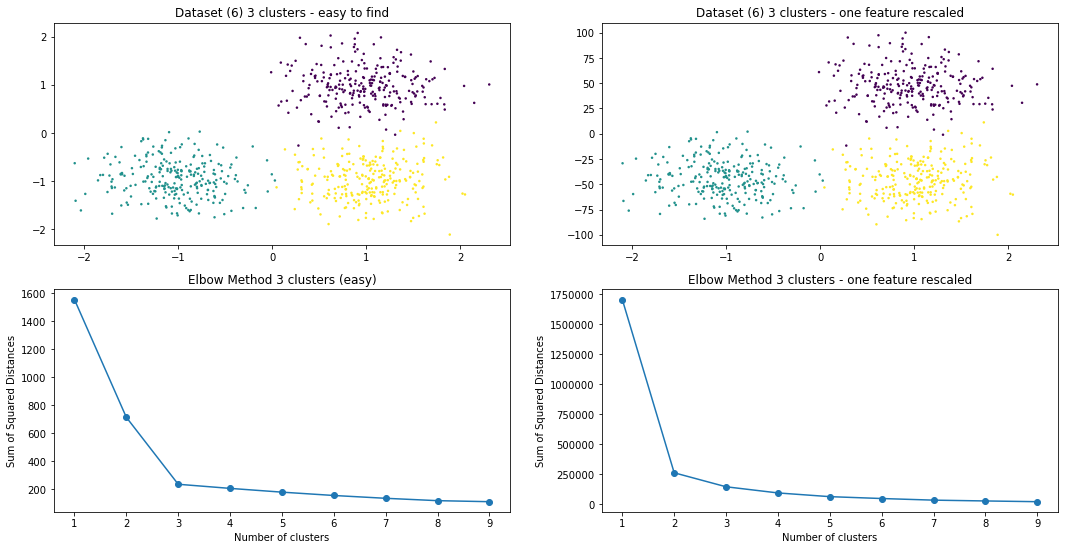

In [61]:
plt.figure(figsize=(18, 9))

X6, y6= make_blobs(n_samples=750, centers=[[1, 1], [-1, -1], [1, -1]], cluster_std=0.4, random_state=111)
plt.subplot(221)
plt.scatter(X6[:, 0], X6[:, 1], marker='.', c=y6, s=25, edgecolor='none')
plt.title('Dataset (6) 3 clusters - easy to find')

SSD = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, init='random')
    kmeans.fit(X6)
    SSD.append(kmeans.inertia_)
plt.subplot(223)    
plt.plot(range(1, 10), SSD, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method 3 clusters (easy)')

# rescale one of the features
X6[:, 1] = np.interp(X6[:, 1], (X6[:, 1].min(), X6[:, 1].max()), (-100, +100))

plt.subplot(222)
plt.scatter(X6[:, 0], X6[:, 1], marker='.', c=y6, s=25, edgecolor='none')
plt.title('Dataset (6) 3 clusters - one feature rescaled')

SSD = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, init='random')
    kmeans.fit(X6)
    SSD.append(kmeans.inertia_)
plt.subplot(224)    
plt.plot(range(1, 10), SSD, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method 3 clusters - one feature rescaled')


plt.show()

So we have 6 datasets up to now. Each one of them will consist of 750 samples. 

* *(1)\_Non\_Cluster data*  - 15 cluster centers with high standard deviation
* *(2) Non Spherical data* - there are two features with high distance btw them.  
* *(3) Many Clusters* - 50 clusters with standard deviation 0.7  
* *(4) Different Cluster Sizes* - 650 samples are used for the size of one of the three clusters, both the rest account for 50 samples; standard deviation is set to one.   
* *(5) Different Cluster Densities* -  3 clusters, one of them has standard deviation of 0.7,  others 2.5
* *(6) 3 clusters, hard to find* - one of the both features is rescaled in the range from -100 to +100

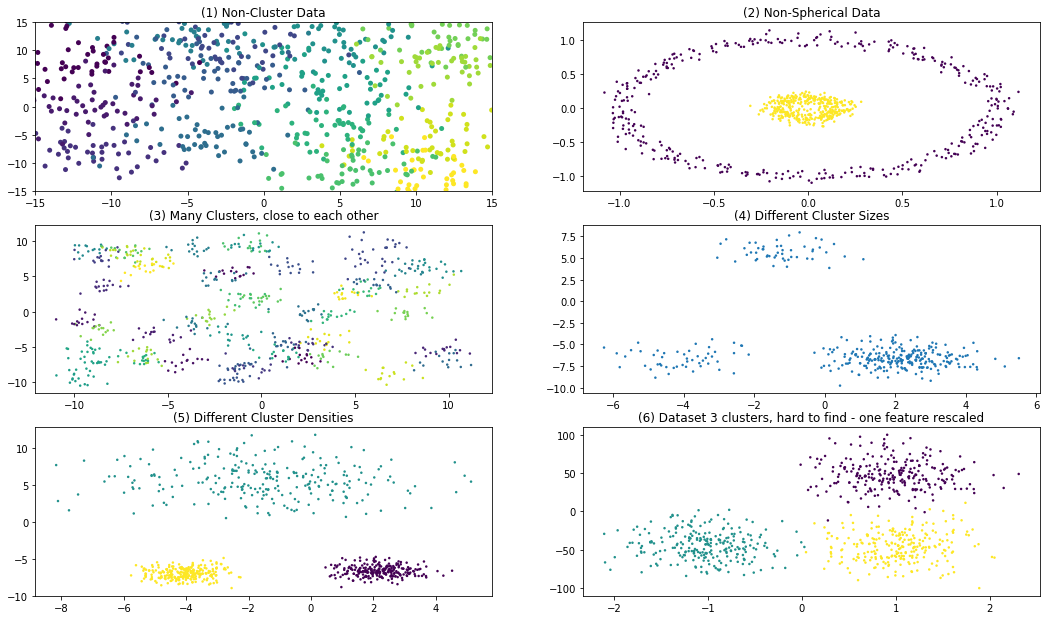

None


In [186]:
plt.figure(figsize=(18, 18))
# (1) Non-Cluster Data
X1, y1 = make_blobs(n_samples=750, centers=[(-12, 8), (-11, 0), (-11, -8), 
                                           (-3, 12), (-3.5, 6), (-3, -6), (-4.5, 12), 
                                           (5, 12), (4, 4), (4, -4), (5.5, -11.5),
                                            (12, 12), (11.8, 7), (11, -6), (12, -12)], n_features=2, cluster_std=3.0, 
                                            random_state=111)
plt.subplot(521)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=y1, s=25, edgecolor='none')
plt.axis([-15, 15, -15, 15])
plt.title("(1) Non-Cluster Data")

# (2) Non-Spherical Data
X2, y2 = make_circles(n_samples=750, factor=.15, noise=0.05, random_state=111)
plt.subplot(522)
plt.scatter(X2[:, 0], X2[:, 1], marker='.', c=y2, s=25, edgecolor='none')
plt.title("(2) Non-Spherical Data")

# (3) Many Clusters, close to each other
X3, y3 = make_blobs(n_samples=750, n_features=2, centers=50, cluster_std=0.7, random_state=111)
plt.subplot(523)
plt.scatter(X3[:, 0], X3[:, 1], marker='.', c=y3, s=25, edgecolor='none')
plt.title("(3) Many Clusters, close to each other")

# (4) Different Cluster Sizes
X4, y4 = make_blobs(n_samples=750, n_features=2, centers = 3, cluster_std=1, random_state=111)
X4 = np.vstack((X4[y4 == 0][:650], X4[y4 == 1][:50], X4[y4 == 2][:50]))
plt.subplot(524)
plt.scatter(X4[:, 0], X4[:, 1], marker='.', s=25, edgecolor='none')
plt.title("(4) Different Cluster Sizes")


# (5) Different Cluster Densities
X5, y5 = make_blobs(n_samples=750, n_features=2, centers = 3, cluster_std=[0.7, 2.5, 0.7], random_state=111)
plt.subplot(525)
plt.scatter(X5[:, 0], X5[:, 1], marker='.', c=y5, s=25, edgecolor='none')
plt.title("(5) Different Cluster Densities")

# (6) Three clusters, one feature rescaled
plt.subplot(526)
plt.scatter(X6[:, 0], X6[:, 1], marker='.', c=y6, s=25, edgecolor='none')
plt.title('(6) Dataset 3 clusters, hard to find - one feature rescaled')


print(plt.show())

## Density Based Clustering

For each dataset we I  determine the best value of *eps* and *min_samples* regarding the following metrics:    
* **Adjusted Rand index**: a function that measures the similarity of the two assignments, ignoring permutations and with chance normalization. Perfect labeling is scored 1.0  
* **Silhouette Coefficient**:  higher score relates to a model with better defined clusters.    
* Using conditional entropy analysis Rosenberg and Hirschberg (2007) define the following two desirable objectives for any cluster assignment.  
	- **homogeneity**: each cluster contains only members of a single class.  
	- **completeness**: all members of a given class are assigned to the same cluster.    
  	- **V-measure**: their harmonic mean   
  
To provide a value for epsilon which defines the maximum distance between two points I will use an  approach for automatically determining the optimal value for Eps. It is described in the following paper: https://iopscience.iop.org/article/10.1088/1755-1315/31/1/012012/pdf

### Discussion

Below is the source code of the analysis, scores and plots. As it is too much, I will provide first a summary of the outcomes.   

* **Dataset 1 - Non Cluster Data**  
Clustering is on general scale level sensitive algorithm. Of course DBSCAN needs a lower value for *eps* when data is standardized. 1.6 with non-scaled and 0.18 for scaled data is the best value for  *eps*.  Comparing to the result from the K-Means estimation (Assignment for week 7) DBSCAN with the Euclidean metric divides the data into more clusters - 10 and 11 insted of 4.  
I use two more metrics - the maximum (Chebyshev) and the Manhattan distance measure. Both of them together with the  Euclidean distances are methods based on capturing the geometrical point separation.  
In noisy dataset like this the Chebyeshev metric finds few clusters - 3. That is because it is a metric where the distance between two vectors is the maximum of their differences. However clusters are more heterogenous according to the Entropy measures like Homegeneity Score, and Completeness - so it performs worse even than the Manhattan metric.   
The latter captures the distance between two points by aggregating the pairwise absolute difference between each feature while Euclidean distance captures the same by aggregating the squared difference in each feature. That is why the Euclidean metric outperforms the Manhattan on this noisy dataset. It tends to cluster points which are further of each other. Usually absolute value distance is more robust, however in our task we have to stick to the best parameters for the Euclidian metric.   
  
* **Dataset 2 - Non Spherical Data**   
DBSCAN based on the Euclidean distances as a distance measurement for building group performs well on Non-Spherical data. Optimal *Eps* is 0.04 for non-standarized and 0.08 for standarized data. Best *Min_Samples* is 7. With this values the data is clustered into two groups, but a high amount of points were not classified - 388. DBSCAN with the Chebyshev and Manhatten metrics fails to cluster the data properly with the chosen parameters.   
   
* **Dataset 3 Many Clusters, close to each other - 50 clusters with standard deviation 0.7**  
DBSCAN manages to group the data into 50 clusters when *eps* is 0.56 for non-standarized and 0.1 for standarized data, leaving just 60 ungrouped points.  As the clusters are many and there are just 750 samples the optimal *Min_Samples* value is the lowest possible - 2. That is due also to the relatively high standard deviation.     
  
* **Dataset 4 -  Different Cluster Sizes, 3 clusters**   
DBSCAN with Euclidean distances performs best when *eps* is 0.6 for non-standarized and 0.2 for standarized data. It groups better when data is scaled. That is why also the number of noise points is less with scaled data.   
    
* **Dataset 5 -  Different Cluster Densities, 3 clusters**  
On this dataset the algorithm groups better when the features are standarized. That is because one of the clusters has higher standard deviation. It finds 3 clusters with *eps* equal to 0.7 for non-standarized and 0.3 for standarized data. *Min_Samples* has to be 9. However the best results are delivered when DBSCAN is used with the Chebyeshev metric on scaled data. Adjusted Rand Index is  0.971 and the Homogeniety Score is 1.   
  
* **Dataset 6 -  Three clusters, one feature re-scaled** 
As expected, DBSCAN performs better, when the features are standardized. With the Eucledean Distances as metric the three clusters are found when *eps* is .3 for standarized data and *min_Samples* 12. Then the Adjusted Rand Index is 0.937, clusters are homogenous and 25 points are unlabeled to a group. DBSCAN based on the Manhatten Metric also determines the correct clsuter number, when the data is standarized.  

* **Dataset  Iris flowers**
Optimal parameters for the DBSCAN algorithm with the euclidean distances to cluster properly the three types of flowers are *eps*=0.6  and *min_samples*=3 for non-standarized data. As the feautires in this data set are on similar scale level, standarizing them does not lead to imporovement.  

## Self-Organizing Maps

Thre new datasets are added. N = 750 for each one.  

* *Dataset (7) - 3 features, 5 clusters, cluster standard deviation 0.5  
* *Dataset (8) - 4 features, 7 clusters with cluster standard deviation 0.75 
* *Dataset (9) - 5 features, 9 clusters with cluster standard deviation 1  

We train individual SOMs on these datasets:

In [201]:
# (7) Three dimensions
X7, y7 = make_blobs(n_samples=750, n_features=3, centers=5, cluster_std=0.5, random_state=111)

# (8) Four dimensions
X8, y8 = make_blobs(n_samples=750, n_features=4, centers=7, cluster_std=0.75, random_state=111)

# (9) Five dimensions
X9, y9 = make_blobs(n_samples=750, n_features=5, centers=8, cluster_std=1, random_state=111)


In [202]:

som1 = MiniSom(6, 6, 3, sigma=0.3, learning_rate=0.5) # initialization of 6x6 SOM
som1.train_random(X7, 100) # trains the SOM with 100 iterations

som2 = MiniSom(6, 6, 4, sigma=0.3, learning_rate=0.5) # initialization of 6x6 SOM
som2.train_random(X8, 100) # trains the SOM with 100 iterations

som3 = MiniSom(6, 6, 5, sigma=0.3, learning_rate=0.5) # initialization of 6x6 SOM
som3.train_random(X9, 100) # trains the SOM with 100 iterations




Now we have three  6-by-6 SOMs trained on the new datasets... 



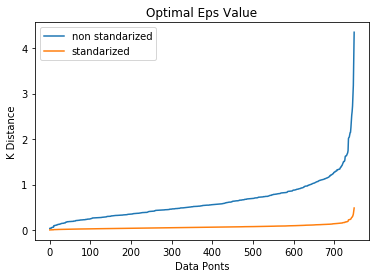

Dataset (1) - No-Cluster Data, Euclidean Metric, no data scaling
Best Value for Eps: 1.60
Best value for min_samples: 7
Estimated number of clusters: 8
Estimated number of noise points: 168
Adjusted Rand Index: 0.127
Silhouette Score: -0.063
Homogeneity: 0.310
Completeness: 0.527
V-measure: 0.390

Dataset (1) - No-Cluster Data, Euclidean Metric with data scaling
Best Value for Eps: 0.18
Best value for min_samples: 7
Estimated number of clusters: 8
Estimated number of noise points: 155
Adjusted Rand Index: 0.133
Silhouette Score: 0.002
Homogeneity: 0.313
Completeness: 0.532
V-measure: 0.394

Dataset (1) - No-Cluster Data, Manhattan distance,  no data scaling
Best Value for Eps: 1.60
Best value for min_samples: 7
Estimated number of clusters: 22
Estimated number of noise points: 371
Adjusted Rand Index: 0.055
Silhouette Score: -0.150
Homogeneity: 0.369
Completeness: 0.467
V-measure: 0.412

Dataset (1) - No-Cluster Data, Chebyeshev Metric no data scaling
Best Value for Eps: 1.60
Best valu

In [23]:
# code snippets from the sklearn library examples were used

# Dataset 1 - No-Cluster Data. 
# Determine the best eps and min_samples value

# standarize the features
X1_sc = StandardScaler().fit_transform(X1)
# find best eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X1)
distances, indices = nbrs.kneighbors(X1)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, label='non standarized')

nbrs = neigh.fit(X1_sc)
distances, indices = nbrs.kneighbors(X1_sc)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, label='standarized')
plt.legend()
plt.ylabel('K Distance')
plt.xlabel('Data Ponts')
plt.title('Optimal Eps Value')
plt.show()


# A. - 1)
db = DBSCAN(eps=1.6, min_samples=7, metric='euclidean').fit(X1)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  # Number of clusters in labels, 
n_noise_ = list(labels).count(-1)                            # ignoring noise if present.

print('Dataset (1) - No-Cluster Data, Euclidean Metric, no data scaling')
print("Best Value for Eps: %0.2f" % db.eps)
print("Best value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y1, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X1, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y1, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y1, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y1, labels))
print()

# B. - 1)
db = DBSCAN(eps=0.18, min_samples=7, metric='euclidean').fit(X1_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (1) - No-Cluster Data, Euclidean Metric with data scaling')
print("Best Value for Eps: %0.2f" % db.eps)
print("Best value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y1, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X1, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y1, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y1, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y1, labels))
print()
# C. - 1)
db = DBSCAN(eps=1.6, min_samples=7, metric='manhattan').fit(X1)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (1) - No-Cluster Data, Manhattan distance,  no data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y1, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X1, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y1, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y1, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y1, labels))
print()

db = DBSCAN(eps=1.6, min_samples=7, metric='chebyshev').fit(X1)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (1) - No-Cluster Data, Chebyeshev Metric no data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y1, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X1, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y1, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y1, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y1, labels))
print()
# D. - 1)

db = DBSCAN(eps=0.18, min_samples=7, metric='manhattan').fit(X1_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (1) - No-Cluster Data, Manhattan distance with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y1, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X1, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y1, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y1, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y1, labels))
print()

db = DBSCAN(eps=0.18, min_samples=7, metric='chebyshev').fit(X1_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (1) - No-Cluster Data, Chebyshev with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y1, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X1, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y1, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y1, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y1, labels))
print()

# E - 1

db = DBSCAN(eps=0.18, min_samples=9, metric='euclidean').fit(X1_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (1) - No-Cluster Data, bad parameters,  Euclidean Metric with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y1, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X1, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y1, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y1, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y1, labels))
print()

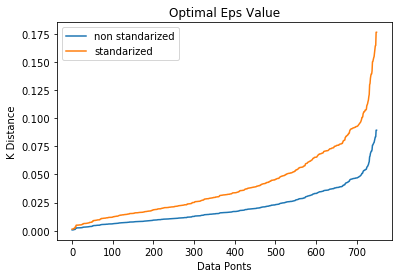

Dataset (2) Non-Spherical Data, Euclidean Metric, no data scaling
Best Value for Eps: 0.04
Best value for min_samples: 7
Estimated number of clusters: 2
Estimated number of noise points: 388
Adjusted Rand Index: 0.879
Silhouette Score: 0.196
Homogeneity: 0.848
Completeness: 0.796
V-measure: 0.822

Dataset (2) Non-Spherical Data, Euclidean Metric with data scaling
Best Value for Eps: 0.08
Best value for min_samples: 7
Estimated number of clusters: 2
Estimated number of noise points: 388
Adjusted Rand Index: 0.879
Silhouette Score: 0.196
Homogeneity: 0.848
Completeness: 0.796
V-measure: 0.822

Dataset (2) Non-Spherical Data, Manhattan distance,  no data scaling
Value for Eps: 0.04
Value for min_samples: 7
Estimated number of clusters: 1
Estimated number of noise points: 434
Adjusted Rand Index: 0.710
Silhouette Score: 0.172
Homogeneity: 0.668
Completeness: 0.680
V-measure: 0.674

Dataset (2) Non-Spherical Data, Chebyeshev Metric no data scaling
Value for Eps: 0.04
Value for min_samples: 

In [56]:
# code snippets from the sklearn library examples were used

# Dataset (2) Non-Spherical Data
# Determine the best eps and min_samples value


# find best eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X2)
distances, indices = nbrs.kneighbors(X2)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, label='non standarized')
# standarize the features
X2_sc = StandardScaler().fit_transform(X2)

nbrs = neigh.fit(X2_sc)
distances, indices = nbrs.kneighbors(X2_sc)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, label='standarized')
plt.legend()
plt.ylabel('K Distance')
plt.xlabel('Data Ponts')
plt.title('Optimal Eps Value')
plt.show()


# A. - 1)
db = DBSCAN(eps=0.04, min_samples=7, metric='euclidean').fit(X2)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  
n_noise_ = list(labels).count(-1)                            

print('Dataset (2) Non-Spherical Data, Euclidean Metric, no data scaling')
print("Best Value for Eps: %0.2f" % db.eps)
print("Best value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y2, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X2, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y2, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y2, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y2, labels))
print()

# B. - 1)
db = DBSCAN(eps=0.08, min_samples=7, metric='euclidean').fit(X2_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (2) Non-Spherical Data, Euclidean Metric with data scaling')
print("Best Value for Eps: %0.2f" % db.eps)
print("Best value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y2, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X2, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y2, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y2, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y2, labels))
print()
# C. - 1)
db = DBSCAN(eps=0.04, min_samples=7, metric='manhattan').fit(X2)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (2) Non-Spherical Data, Manhattan distance,  no data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y2, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X2, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y2, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y2, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y2, labels))
print()

db = DBSCAN(eps=0.04, min_samples=7, metric='chebyshev').fit(X2)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (2) Non-Spherical Data, Chebyeshev Metric no data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y2, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X2, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y2, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y2, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y2, labels))
print()

# D. - 1)

db = DBSCAN(eps=0.08, min_samples=7, metric='manhattan').fit(X2_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (2) Non-Spherical Data, Manhattan distance with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y2, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X2, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y2, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y2, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y2, labels))
print()

db = DBSCAN(eps=0.04, min_samples=7, metric='chebyshev').fit(X2_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (2) Non-Spherical Data, Chebyshev with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y2, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X2, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y2, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y2, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y2, labels))
print()


# E - 1

db = DBSCAN(eps=0.08, min_samples=7, metric='euclidean').fit(X2_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (2) Non-Spherical Data, bad parameters,  Euclidean Metric with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y2, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X2, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y2, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y2, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y2, labels))
print()

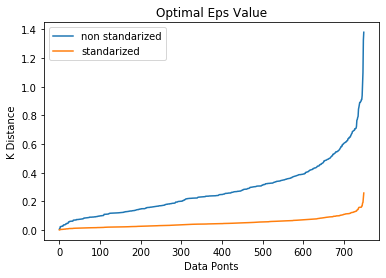

Dataset (3) - Many Clusters - close , Euclidean Metric, no data scaling
Best Value for Eps: 0.56
Best value for min_samples: 2
Estimated number of clusters: 50
Estimated number of noise points: 61
Adjusted Rand Index: 0.228
Silhouette Score: 0.091
Homogeneity: 0.633
Completeness: 0.809
V-measure: 0.710

Dataset (3) - Many Clusters - close , Euclidean Metric with data scaling
Best Value for Eps: 0.10
Best value for min_samples: 2
Estimated number of clusters: 51
Estimated number of noise points: 61
Adjusted Rand Index: 0.228
Silhouette Score: 0.103
Homogeneity: 0.635
Completeness: 0.805
V-measure: 0.710

Dataset (3) - Many Clusters - close , Manhattan distance,  no data scaling
Value for Eps: 0.56
Value for min_samples: 7
Estimated number of clusters: 13
Estimated number of noise points: 576
Adjusted Rand Index: 0.009
Silhouette Score: -0.399
Homogeneity: 0.185
Completeness: 0.652
V-measure: 0.288

Dataset (3) - Many Clusters - close , Chebyeshev Metric no data scaling
Value for Eps: 0.

In [52]:
# code snippets from the sklearn library examples were used

# Dataset (3) Many Clusters, close 
# Determine the best eps and min_samples value


# find best eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X3)
distances, indices = nbrs.kneighbors(X3)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, label='non standarized')
# standarize the features
X3_sc = StandardScaler().fit_transform(X3)

nbrs = neigh.fit(X3_sc)
distances, indices = nbrs.kneighbors(X3_sc)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, label='standarized')
plt.legend()
plt.ylabel('K Distance')
plt.xlabel('Data Ponts')
plt.title('Optimal Eps Value')
plt.show()


# A. - 1)
db = DBSCAN(eps=0.56, min_samples=2, metric='euclidean').fit(X3)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  
n_noise_ = list(labels).count(-1)                            

print('Dataset (3) - Many Clusters - close , Euclidean Metric, no data scaling')
print("Best Value for Eps: %0.2f" % db.eps)
print("Best value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y3, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X3, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y3, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y3, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y3, labels))
print()

# B. - 1)
db = DBSCAN(eps=0.1, min_samples=2, metric='euclidean').fit(X3_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (3) - Many Clusters - close , Euclidean Metric with data scaling')
print("Best Value for Eps: %0.2f" % db.eps)
print("Best value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y3, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X3, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y3, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y3, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y3, labels))
print()
# C. - 1)
db = DBSCAN(eps=0.56, min_samples=7, metric='manhattan').fit(X3)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (3) - Many Clusters - close , Manhattan distance,  no data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y3, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X3, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y3, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y3, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y3, labels))
print()

db = DBSCAN(eps=0.56, min_samples=7, metric='chebyshev').fit(X3)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (3) - Many Clusters - close , Chebyeshev Metric no data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y3, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X3, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y3, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y3, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y3, labels))
print()

# D. - 1)

db = DBSCAN(eps=0.1, min_samples=7, metric='manhattan').fit(X3_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (3) - Many Clusters - close , Manhattan distance with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y3, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X3, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y3, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y3, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y3, labels))
print()

db = DBSCAN(eps=0.1, min_samples=7, metric='chebyshev').fit(X3_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (3) - Many Clusters - close , Chebyshev with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y3, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X3, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y3, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y3, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y3, labels))
print()


# E - 1

db = DBSCAN(eps=0.1, min_samples=7, metric='euclidean').fit(X3_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (3) - Many Clusters - close , bad parameters,  Euclidean Metric with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y3, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X3, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y3, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y3, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y3, labels))
print()

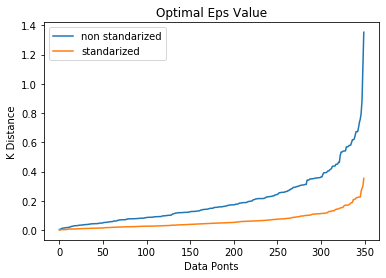

Dataset (4) - Different Cluster Sizes, Euclidean Metric, no data scaling
Best Value for Eps: 0.60
Best value for min_samples: 4
Estimated number of clusters: 3
Estimated number of noise points: 39

Dataset (4) - Different Cluster Sizes, Euclidean Metric with data scaling
Best Value for Eps: 0.20
Best value for min_samples: 4
Estimated number of clusters: 3
Estimated number of noise points: 26

Dataset (4) - Different Cluster Sizes, Manhattan distance,  no data scaling
Value for Eps: 0.56
Value for min_samples: 4
Estimated number of clusters: 6
Estimated number of noise points: 73

Dataset (4) - Different Cluster Sizes, Chebyeshev Metric no data scaling
Value for Eps: 0.56
Value for min_samples: 4
Estimated number of clusters: 3
Estimated number of noise points: 32

Dataset (4) - Different Cluster Sizes, Manhattan distance with data scaling
Value for Eps: 0.20
Value for min_samples: 4
Estimated number of clusters: 4
Estimated number of noise points: 44

Dataset (4) - Different Cluster S

In [83]:
# code snippets from the sklearn library examples were used

# Dataset (4) -  Different Cluster Sizes
# Determine the best eps and min_samples value


# find best eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X4)
distances, indices = nbrs.kneighbors(X4)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, label='non standarized')
# standarize the features
X4_sc = StandardScaler().fit_transform(X4)

nbrs = neigh.fit(X4_sc)
distances, indices = nbrs.kneighbors(X4_sc)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, label='standarized')
plt.legend()
plt.ylabel('K Distance')
plt.xlabel('Data Ponts')
plt.title('Optimal Eps Value')
plt.show()


# A. - 1)
db = DBSCAN(eps=0.6, min_samples=4, metric='euclidean').fit(X4)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  
n_noise_ = list(labels).count(-1)                            

print('Dataset (4) - Different Cluster Sizes, Euclidean Metric, no data scaling')
print("Best Value for Eps: %0.2f" % db.eps)
print("Best value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print()

# B. - 1)
db = DBSCAN(eps=0.2, min_samples=4, metric='euclidean').fit(X4_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (4) - Different Cluster Sizes, Euclidean Metric with data scaling')
print("Best Value for Eps: %0.2f" % db.eps)
print("Best value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print()
# C. - 1)
db = DBSCAN(eps=0.56, min_samples=4, metric='manhattan').fit(X4)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (4) - Different Cluster Sizes, Manhattan distance,  no data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print()

db = DBSCAN(eps=0.56, min_samples=4, metric='chebyshev').fit(X4)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (4) - Different Cluster Sizes, Chebyeshev Metric no data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print()

# D. - 1)

db = DBSCAN(eps=0.2, min_samples=4, metric='manhattan').fit(X4_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (4) - Different Cluster Sizes, Manhattan distance with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print()

db = DBSCAN(eps=0.2, min_samples=4, metric='chebyshev').fit(X4_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (4) - Different Cluster Sizes, Chebyshev with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print()


# E - 1

db = DBSCAN(eps=0.2, min_samples=4, metric='euclidean').fit(X4_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (4) - Different Cluster Sizes, bad parameters,  Euclidean Metric with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print()

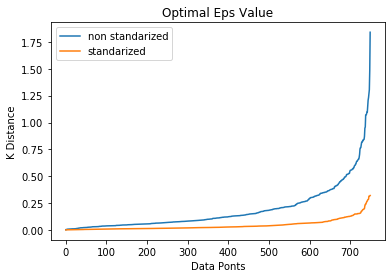

Dataset (5) - Different Cluster Densities, Euclidean Metric, no data scaling
Best Value for Eps: 0.70
Best value for min_samples: 9
Estimated number of clusters: 3
Estimated number of noise points: 146
Adjusted Rand Index: 0.862
Silhouette Score: 0.556
Homogeneity: 0.980
Completeness: 0.810
V-measure: 0.887

Dataset (5) - Different Cluster Densities, Euclidean Metric with data scaling
Best Value for Eps: 0.30
Best value for min_samples: 9
Estimated number of clusters: 3
Estimated number of noise points: 22
Adjusted Rand Index: 0.959
Silhouette Score: 0.650
Homogeneity: 1.000
Completeness: 0.917
V-measure: 0.957

Dataset (5) - Different Cluster Densities, Manhattan distance,  no data scaling
Value for Eps: 0.70
Value for min_samples: 9
Estimated number of clusters: 6
Estimated number of noise points: 185
Adjusted Rand Index: 0.839
Silhouette Score: 0.440
Homogeneity: 0.945
Completeness: 0.728
V-measure: 0.822

Dataset (5) - Different Cluster Densities, Chebyeshev Metric no data scaling


In [99]:
# Dataset 5 -  Different Cluster Densities, 3 clusters

# find best eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X5)
distances, indices = nbrs.kneighbors(X5)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, label='non standarized')
# standarize the features
X5_sc = StandardScaler().fit_transform(X5)

nbrs = neigh.fit(X5_sc)
distances, indices = nbrs.kneighbors(X5_sc)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, label='standarized')
plt.legend()
plt.ylabel('K Distance')
plt.xlabel('Data Ponts')
plt.title('Optimal Eps Value')
plt.show()


# A. - 1)
db = DBSCAN(eps=0.7, min_samples=9, metric='euclidean').fit(X5)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  
n_noise_ = list(labels).count(-1)                            

print('Dataset (5) - Different Cluster Densities, Euclidean Metric, no data scaling')
print("Best Value for Eps: %0.2f" % db.eps)
print("Best value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y5, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X5, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y5, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y5, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y5, labels))
print()

# B. - 1)
db = DBSCAN(eps=0.3, min_samples=9, metric='euclidean').fit(X5_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (5) - Different Cluster Densities, Euclidean Metric with data scaling')
print("Best Value for Eps: %0.2f" % db.eps)
print("Best value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y5, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X5, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y5, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y5, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y5, labels))
print()
# C. - 1)
db = DBSCAN(eps=0.7, min_samples=9, metric='manhattan').fit(X5)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (5) - Different Cluster Densities, Manhattan distance,  no data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y5, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X5, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y5, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y5, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y5, labels))
print()

db = DBSCAN(eps=0.7, min_samples=9, metric='chebyshev').fit(X5)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (5) - Different Cluster Densities, Chebyeshev Metric no data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y5, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X5, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y5, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y5, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y5, labels))
print()

# D. - 1)

db = DBSCAN(eps=0.3, min_samples=9, metric='manhattan').fit(X5_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (5) - Different Cluster Densities, Manhattan distance with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y5, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X5, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y5, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y5, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y5, labels))
print()

db = DBSCAN(eps=0.3, min_samples=9, metric='chebyshev').fit(X5_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (5) - Different Cluster Densities, Chebyshev with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y5, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X5, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y5, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y5, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y5, labels))
print()


# E - 1

db = DBSCAN(eps=0.1, min_samples=7, metric='euclidean').fit(X5_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (5) - Different Cluster Densities, bad parameters,  Euclidean Metric with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y5, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X5, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y5, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y5, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y5, labels))
print()

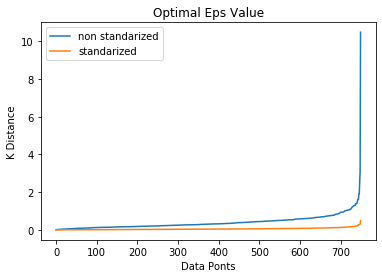

Dataset (6) - Three Clusters, one feature re-scaled, Euclidean Metric, no data scaling
Best Value for Eps: 1.80
Best value for min_samples: 12
Estimated number of clusters: 3
Estimated number of noise points: 164
Adjusted Rand Index: 0.330
Silhouette Score: 0.407
Homogeneity: 0.444
Completeness: 0.435
V-measure: 0.439

Dataset (6) - Three Clusters, one feature re-scaled, Euclidean Metric with data scaling
Best Value for Eps: 0.30
Best value for min_samples: 12
Estimated number of clusters: 3
Estimated number of noise points: 25
Adjusted Rand Index: 0.937
Silhouette Score: 0.219
Homogeneity: 0.945
Completeness: 0.859
V-measure: 0.900

Dataset (6) - Three Clusters, one feature re-scaled, Manhattan distance,  no data scaling
Value for Eps: 1.80
Value for min_samples: 12
Estimated number of clusters: 6
Estimated number of noise points: 221
Adjusted Rand Index: 0.214
Silhouette Score: -0.085
Homogeneity: 0.412
Completeness: 0.319
V-measure: 0.359

Dataset (6) - Three Clusters, one feature r

In [128]:
# Dataset 6 -  Three clusters, one feature rescaled

# find best eps
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X6)
distances, indices = nbrs.kneighbors(X6)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, label='non standarized')
# standarize the features
X6_sc = StandardScaler().fit_transform(X6)

nbrs = neigh.fit(X6_sc)
distances, indices = nbrs.kneighbors(X6_sc)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, label='standarized')
plt.legend()
plt.ylabel('K Distance')
plt.xlabel('Data Ponts')
plt.title('Optimal Eps Value')
plt.show()


# A. - 1)
db = DBSCAN(eps=1.8, min_samples=12, metric='euclidean').fit(X6)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)  
n_noise_ = list(labels).count(-1)                            

print('Dataset (6) - Three Clusters, one feature re-scaled, Euclidean Metric, no data scaling')
print("Best Value for Eps: %0.2f" % db.eps)
print("Best value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y6, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X6, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y6, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y6, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y6, labels))
print()

# B. - 1)
db = DBSCAN(eps=0.3, min_samples=12, metric='euclidean').fit(X6_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (6) - Three Clusters, one feature re-scaled, Euclidean Metric with data scaling')
print("Best Value for Eps: %0.2f" % db.eps)
print("Best value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y6, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X6, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y6, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y6, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y6, labels))
print()
# C. - 1)
db = DBSCAN(eps=1.8, min_samples=12, metric='manhattan').fit(X6)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (6) - Three Clusters, one feature re-scaled, Manhattan distance,  no data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y6, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X6, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y6, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y6, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y6, labels))
print()

db = DBSCAN(eps=1.8, min_samples=12, metric='chebyshev').fit(X6)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (6) - Three Clusters, one feature re-scaled, Chebyeshev Metric no data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y6, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X6, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y6, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y6, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y6, labels))
print()

# D. - 1)

db = DBSCAN(eps=0.3, min_samples=12, metric='manhattan').fit(X6_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (6) - Three Clusters, one feature re-scaled, Manhattan distance with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y6, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X6, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y6, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y6, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y6, labels))
print()

db = DBSCAN(eps=0.3, min_samples=12, metric='chebyshev').fit(X6_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (6) - Three Clusters, one feature re-scaled, Chebyshev with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y6, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X6, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y6, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y6, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y6, labels))
print()


# E - 1

db = DBSCAN(eps=0.4, min_samples=13, metric='euclidean').fit(X6_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (6) - Three Clusters, one feature re-scaled, bad parameters,  Euclidean Metric with data scaling')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y6, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X6, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y6, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y6, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y6, labels))
print()

In [181]:
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

db = DBSCAN(eps=0.6, min_samples=3, metric='euclidean').fit(X_iris)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (7) - Iris Flowers')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y_iris, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X_iris, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_iris, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y_iris, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y_iris, labels))
print()

# standarize the features
X_iris_sc = StandardScaler().fit_transform(X_iris)

db = DBSCAN(eps=0.15, min_samples=3, metric='euclidean').fit(X_iris_sc)
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Dataset (7) - Iris Flowers')
print("Value for Eps: %0.2f" % db.eps)
print("Value for min_samples: %d" % db.min_samples)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y_iris, labels))
print("Silhouette Score: %0.3f" % metrics.silhouette_score(X_iris, labels))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y_iris, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y_iris, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y_iris, labels))
print()

Dataset (7) - Iris Flowers
Value for Eps: 0.60
Value for min_samples: 3
Estimated number of clusters: 3
Estimated number of noise points: 5
Adjusted Rand Index: 0.540
Silhouette Score: 0.423
Homogeneity: 0.598
Completeness: 0.750
V-measure: 0.665

Dataset (7) - Iris Flowers
Value for Eps: 0.15
Value for min_samples: 3
Estimated number of clusters: 3
Estimated number of noise points: 140
Adjusted Rand Index: 0.011
Silhouette Score: 0.082
Homogeneity: 0.071
Completeness: 0.246
V-measure: 0.110

